In [1]:
import os
os.chdir("d:/python_projects/london-city-bikes")

import numpy as np
import torch
import optuna
from optuna.trial import TrialState

c:\Users\huber\anaconda3\envs\torch-cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.dataset_all_clusters import get_dataloaders
from src.model import LSTMModel, LinearWeightedMSELoss
from src.train import train_model, DEVICE

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [3]:
PRED_LENGTH = 48

print(f"Using device: {DEVICE}")

Using device: cuda


# Tuning

In [4]:
# Hyperparameters
INPUT_SIZE = 12
FUTURE_FEATURE_SIZE = 10
OUTPUT_SIZE = 2 * PRED_LENGTH
USE_CLUSTER_EMBEDDING = True
NUM_OF_EPOCHS = 30
PATIENCE = 5

NUM_OF_TRIALS = 10
TIMEOUT = 3600 * 2

In [ ]:
def objective(trial):
    params = {
        'hidden_size': trial.suggest_categorical('hidden_size', [64, 128, 256, 512]),
        'num_layers': trial.suggest_int('num_layers', 1, 2),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5, step=0.1),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [128, 256, 512]),
        #'num_epochs': trial.suggest_int('num_epochs', 10, 30),
        #'patience': trial.suggest_int('patience', 3, 10)
    }
    
    # Create dataloaders with suggested batch size
    train_dataloader, val_dataloader, cluster_id_map = get_dataloaders(batch_size=params['batch_size'])
    
    # Create model with suggested parameters
    model = LSTMModel(
        input_size=INPUT_SIZE,
        hidden_size=params['hidden_size'],
        future_feature_size=FUTURE_FEATURE_SIZE,
        output_size=OUTPUT_SIZE,
        pred_length=PRED_LENGTH,
        num_layers=params['num_layers'],
        dropout=params['dropout'],
        use_cluster_embedding=USE_CLUSTER_EMBEDDING,
        num_clusters=len(cluster_id_map),
        cluster_emb_size=8
    ).to(DEVICE)
    
    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = LinearWeightedMSELoss()
    
    # Run training using your existing function
    _, checkpoint = train_model(
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_OF_EPOCHS,
        use_cluster_embedding=USE_CLUSTER_EMBEDDING,
        patience=PATIENCE
    )
    
    # Report validation loss to Optuna
    val_loss = checkpoint['best_val_loss']
    trial.report(val_loss, checkpoint['epoch'])
    
    # Handle pruning based on intermediate results
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    return val_loss

[I 2025-04-26 21:27:29,062] A new study created in memory with name: no-name-e3b55387-b01f-4703-a675-92b5ed55cb1b
c:\Users\huber\anaconda3\envs\torch-cuda\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch [1/30] - Train Loss: 0.0517, Train MAE: 0.1416, Val Loss: 0.0376, Val MAE: 0.1297
Epoch [2/30] - Train Loss: 0.0324, Train MAE: 0.1153, Val Loss: 0.0277, Val MAE: 0.1130
Epoch [3/30] - Train Loss: 0.0249, Train MAE: 0.1021, Val Loss: 0.0216, Val MAE: 0.0945
Epoch [4/30] - Train Loss: 0.0177, Train MAE: 0.0861, Val Loss: 0.0152, Val MAE: 0.0790
Epoch [5/30] - Train Loss: 0.0117, Train MAE: 0.0710, Val Loss: 0.0113, Val MAE: 0.0682
Epoch [6/30] - Train Loss: 0.0088, Train MAE: 0.0622, Val Loss: 0.0096, Val MAE: 0.0625
Epoch [7/30] - Train Loss: 0.0074, Train MAE: 0.0573, Val Loss: 0.0087, Val MAE: 0.0590
Epoch [8/30] - Train Loss: 0.0067, Train MAE: 0.0544, Val Loss: 0.0082, Val MAE: 0.0569
Epoch [9/30] - Train Loss: 0.0062, Train MAE: 0.0525, Val Loss: 0.0079, Val MAE: 0.0553
Epoch [10/30] - Train Loss: 0.0058, Train MAE: 0.0508, Val Loss: 0.0075, Val MAE: 0.0539
Epoch [11/30] - Train Loss: 0.0055, Train MAE: 0.0493, Val Loss: 0.0073, Val MAE: 0.0525
Epoch [12/30] - Train Loss: 0.

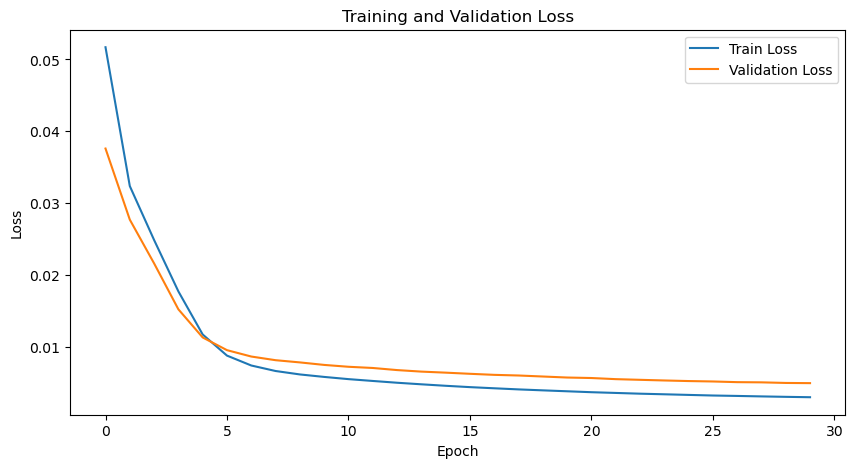

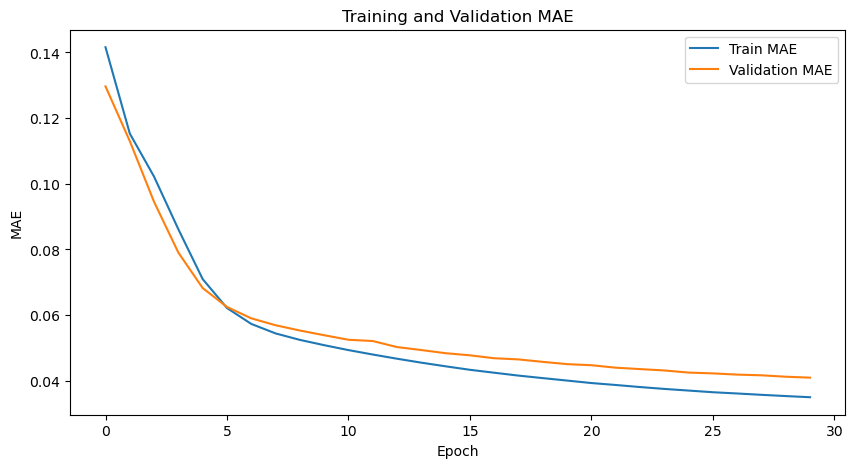

[I 2025-04-26 21:32:01,660] Trial 0 finished with value: 0.004978510426423911 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.5, 'learning_rate': 9.398683303852896e-05, 'batch_size': 256}. Best is trial 0 with value: 0.004978510426423911.


Epoch [1/30] - Train Loss: 0.0620, Train MAE: 0.1583, Val Loss: 0.0572, Val MAE: 0.1500
Epoch [2/30] - Train Loss: 0.0593, Train MAE: 0.1531, Val Loss: 0.0544, Val MAE: 0.1444
Epoch [3/30] - Train Loss: 0.0568, Train MAE: 0.1482, Val Loss: 0.0519, Val MAE: 0.1390
Epoch [4/30] - Train Loss: 0.0544, Train MAE: 0.1433, Val Loss: 0.0494, Val MAE: 0.1339
Epoch [5/30] - Train Loss: 0.0521, Train MAE: 0.1387, Val Loss: 0.0472, Val MAE: 0.1295
Epoch [6/30] - Train Loss: 0.0501, Train MAE: 0.1347, Val Loss: 0.0454, Val MAE: 0.1261
Epoch [7/30] - Train Loss: 0.0482, Train MAE: 0.1313, Val Loss: 0.0438, Val MAE: 0.1236
Epoch [8/30] - Train Loss: 0.0466, Train MAE: 0.1286, Val Loss: 0.0424, Val MAE: 0.1218
Epoch [9/30] - Train Loss: 0.0451, Train MAE: 0.1263, Val Loss: 0.0412, Val MAE: 0.1205
Epoch [10/30] - Train Loss: 0.0437, Train MAE: 0.1245, Val Loss: 0.0401, Val MAE: 0.1198
Epoch [11/30] - Train Loss: 0.0425, Train MAE: 0.1230, Val Loss: 0.0391, Val MAE: 0.1195
Epoch [12/30] - Train Loss: 0.

In [ ]:
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)

study.optimize(objective, n_trials=NUM_OF_TRIALS, timeout=TIMEOUT)

In [ ]:
# Output results
print("Best trial:")
trial = study.best_trial
print(f"  Value (best validation loss): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")



Best trial:
  Value (best validation loss): 0.013566057523712515
  Params: 
    hidden_size: 512
    num_layers: 2
    dropout: 0.0
    learning_rate: 1.7100313462227867e-05
    batch_size: 128


In [ ]:
# Visualize optimization
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [learning_rate (FloatDistribution):
                                0.016092241632559623<extra></extra>, dropout
                                (FloatDistribution):
                                0.03293259586364347<extra></extra>, num_layers
                                (IntDistribution):
                                0.10469242517151021<extra></extra>, batch_size
                                (CategoricalDistribution):
                                0.11598882366499663<extra></extra>, hidden_size
                                (CategoricalDistribution):
                                0.7302939136672901<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [0.02, 0.03, 0.10, 0.12, 0.73],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.016092241632559623, 0.03293259586364347,
                    0.10469242517151021, 0.11598882366499663, 0.7302939136672901],
              'y': [learning_rate, dropout, num_layers, batch_size, hidden_size]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})